In [0]:
class UCB:
    """
    Upper Confidence Bound Algorithm
    :param k: Number of arms
    :param c: degree of exploration
    :param iters: Number of iterations
    :param t: time step count
    :param N_t: number of time steps that action a is selected prior to t 
    :param q_star: True value of each arm
    :param Q_t: estimated value of action (each arm)
    :param Q_total: total stimated value
    :param Q_total_iter: total stimated value for each iteration
    :param reward: reward of selected action
    :param reward_iter: step rewards for each iteration
    :param selec_ac_q_star: selected action true value
    :param selected_ac_true_value_iter: each step's selected action true value 
    for each iteration
    """
    def __init__(self, k, c, iters,seed):
        np.random.seed(seed) 
        random.seed(seed)
        self.seed=seed
        self.k = k 
        self.c = c  
        self.iters = iters
        self.t = 1
        self.N_t = np.ones(k) 
        self.q_star = np.random.normal(0, 1, k)
        self.Q_t = np.zeros(k)
        self.Q_total = 0  
        self.Q_total_iter = np.zeros(iters)
        self.reward_iter = np.zeros(iters)
        self.reward=0
        self.selec_ac_q_star=0
        self.selected_ac_true_value_iter = np.zeros(iters)
           
    def pull(self , train=True):

        # Select action according to UCB Criteria
        a = np.argmax(self.Q_t + self.c * np.sqrt(
                (np.log(self.t)) / self.N_t))
        
        #The true value of selected action (to be used for regret calculation)
        self.selec_ac_q_star = self.q_star[a]

        self.reward = np.random.normal(self.q_star[a], 1)

        if train: 
          # Update time step counts
          self.t += 1
          # Update time step counts for action a
          self.N_t[a] += 1 
          # update estimated value of action a
          self.Q_t[a] = self.Q_t[a] + (
              self.reward - self.Q_t[a]) / self.N_t[a]         
          # Update total estimated value
          self.Q_total = self.Q_total + (
              self.reward - self.Q_total) / self.t

    def run(self):
        for i in range(self.iters):
            self.pull(train=True)
            self.Q_total_iter[i] = self.Q_total
            self.reward_iter[i] = self.reward
            self.selected_ac_true_value_iter[i] = self.selec_ac_q_star 

    def test(self, train_step, test_step):

        reward_test_iter = np.zeros(test_step)
        for i in range(train_step):
            self.pull(train=True)
        for j in range(test_step):
            self.pull(train=False)
            reward_test_iter[j] = self.reward
        return reward_test_iter
                         
    def reset(self):
        # Resets results
        self.t = 1 
        self.N_t = np.ones(self.k)
        self.Q_total = 0
        self.Q_total_iter = np.zeros(self.iters)
        self.Q_t = np.zeros(self.k)
        self.q_star = np.random.normal(0, 1, self.k)
        self.reward_iter = np.zeros(self.iters)
        self.reward=0
        self.selected_ac_true_value_iter = np.zeros(self.iters)

In [0]:
class Boltzmann:
    """
    Boltzmann Algorithm
    :param k: Number of arms
    :param iters: Number of iterations
    :param t: time step count
    :param N_t: number of time steps that action a is selected prior to t 
    :param q_star: True value of each arm
    :param Q_t: estimated value of action (each arm)
    :param Q_total: total stimated value
    :param Q_total_iter: total stimated value for each iteration
    :param reward: reward of selected action
    :param reward_iter: step rewards of each iteration
    :param alpha: The step size (learning rate) 
    :param H: preference of actions
    :param actions: the arm selected
    :param selec_ac_q_star: selected action true value
    :param selected_ac_true_value_iter: each step's selected action true value 
    for each iteration
    """
    def __init__(self, k, alpha, iters, seed):
        np.random.seed(seed) 
        random.seed(seed)
        self.seed=seed
        self.k = k
        self.iters = iters
        self.t = 1
        self.N_t = np.ones(k) 
        self.q_star = np.random.normal(0, 1, k)
        self.Q_t = np.zeros(k)
        self.Q_total = 0 
        self.Q_total_iter = np.zeros(iters)
        self.reward_iter = np.zeros(iters)  
        self.actions = np.arange(k)
        self.H = np.zeros(k)
        self.alpha = alpha 
        self.reward = 0
        self.selec_ac_q_star=0
        self.selected_ac_true_value_iter = np.zeros(iters)

    def pull(self, train=True):
        # action probability according to Softmax distribution
        self.action_prob = np.exp(self.H) \
            / np.sum(np.exp(self.H), axis=0)

        # Select action with highest probability (preference)
        a = np.random.choice(self.actions, p=self.action_prob)

        #The true value of selected action (to be used for regret calculation)
        self.selec_ac_q_star = self.q_star[a]

        #rewards are selected from a normal distribution
        self.reward = np.random.normal(self.q_star[a], 1)

        if train:
          # Update time step counts
          self.t += 1
          # Update time step counts for selected arm
          self.N_t[a] += 1

          # Update total estimated value
          self.Q_total = self.Q_total + (
              self.reward - self.Q_total) / self.t

          # update estimated value of action(arm) a
          self.Q_t[a] = self.Q_t[a] + (
              self.reward - self.Q_t[a]) / self.N_t[a]         

          # Update preferences for selected action a
          self.H[a] = self.H[a] + self.alpha * (self.reward - self.Q_total) * (1 - \
                  self.action_prob[a])
          
          # Update preferences for other actions (except a)
          actions_not_taken = self.actions!=a
          self.H[actions_not_taken] = self.H[actions_not_taken] - \
              self.alpha * (self.reward - self.Q_total) \
              * self.action_prob[actions_not_taken]

    def run(self):
        for i in range(self.iters):
            self.pull(train=True)
            self.Q_total_iter[i] = self.Q_total
            self.reward_iter[i] = self.reward
            self.selected_ac_true_value_iter[i] = self.selec_ac_q_star 

    def test(self, train_step, test_step):
        reward_test_iter = np.zeros(test_step)
        for i in range(train_step):
            self.pull(train=True)
        for j in range(test_step):
            self.pull(train=False)
            reward_test_iter[j] = self.reward
        return reward_test_iter

    def reset(self):
        # Reset parameters
        self.t = 1
        self.N_t = np.ones(self.k)
        self.Q_total = 0
        self.Q_total_iter = np.zeros(self.iters)
        self.Q_t = np.zeros(self.k)
        self.H = np.zeros(self.k)
        self.q_star = np.random.normal(0, 1, self.k)
        self.reward_iter = np.zeros(self.iters)
        self.reward = 0
        self.selected_ac_true_value_iter = np.zeros(self.iters)

In [0]:
import math

class Thompson:
    """
    Thompson Sampling Algorithm
    :param k: Number of arms
    :param iters: Number of iterations
    :param t: time step count
    :param q_star: True value of each arm
    :param Q_t: estimated value of action (each arm)
    :param Q_total: total stimated value
    :param Q_total_iter: total stimated value for each iteration
    :param reward: reward of selected action
    :param reward_iter: step rewards of each iteration
    :param selec_ac_q_star: selected action true value
    :param selected_ac_true_value_iter: each step's selected action true value 
    for each iteration
    :param sample_means: Sample means selected from prior-posterior distribution
    :param mean_0: mean of prior-posterior gaussian distribution
    :param sigma_0: sigma of prior-posterior gaussian distribution
    :param sigma: sigma of reward normal distribution
    :param mean: mean of reward normal distribution
    """

    def __init__(self, k, iters,seed):
        
        np.random.seed(seed) 
        random.seed(seed)
        self.seed=seed
        self.k = k  
        self.iters = iters
        self.q_star = np.random.normal(0, 1, k)
        self.Q_t = np.zeros(k)
        self.N_t = np.ones(k) 
        self.Q_total = 0 
        self.Q_total_iter = np.zeros(iters) 
        self.t = 1
        self.sample_means = np.zeros(self.k)
        self.mean_0 = np.zeros(self.k)#random.normal(0, 1, k)
        self.sigma_0 = np.ones(self.k)
        self.mean = 0
        self.sigma = 2
        self.reward =0
        self.reward_iter = np.zeros(iters)  
        self.selec_ac_q_star=0
        self.selected_ac_true_value_iter = np.zeros(iters)

    def pull(self , train=True):
        #prior-posterior distribution sampling
        for i in range(self.k):
            self.sample_means[i] = np.random.normal(self.mean_0[i],self.sigma_0[i])
        a = np.argmax(self.sample_means)
        #The true value of selected action (to be used for regret calculation)
        self.selec_ac_q_star = self.q_star[a]
        #mean of reward distribution
        self.mean = self.q_star[a]
        self.reward = np.random.normal(self.mean, self.sigma)
        #update posterior sigma
        if train:
          sigma_1 = math.sqrt((self.sigma**-2)+ (self.sigma_0[a]**-2))
          #update posterior mean
          self.mean_0[a] = (sigma_1**2)*((self.mean_0[a]*(self.sigma_0[a]**-2))+(self.reward*(self.sigma**-2)))
          #assign updated sigma to prior sigma for the next step
          self.sigma_0[a] = sigma_1

          # update estimated value of action a
          self.t += 1
          self.Q_total = self.Q_total + (
              self.reward - self.Q_total) / self.t

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.Q_total_iter[i] = self.Q_total
            self.reward_iter[i] = self.reward
            self.selected_ac_true_value_iter[i] = self.selec_ac_q_star

    def test(self, train_step, test_step):
        reward_test_iter = np.zeros(test_step)
        for i in range(train_step):
            self.pull(train=True)
        for j in range(test_step):
            self.pull(train=False)
            reward_test_iter[j] = self.reward
        return reward_test_iter

    def reset(self):
        # Resets results
        self.q_star = np.random.normal(0, 1, self.k)
        self.sample_means = np.zeros(self.k)
        self.Q_t = np.zeros(self.k)
        self.N_t = np.ones(self.k)
        self.Q_total = 0 
        self.Q_total_iter = np.zeros(iters) 
        self.t = 1
        self.mean_0 = np.random.normal(0, 1, k)
        self.sigma_0 = np.ones(self.k)
        self.sigma = 1
        self.selected_ac_true_value_iter = np.zeros(iters)
        self.reward_iter = np.zeros(iters) 

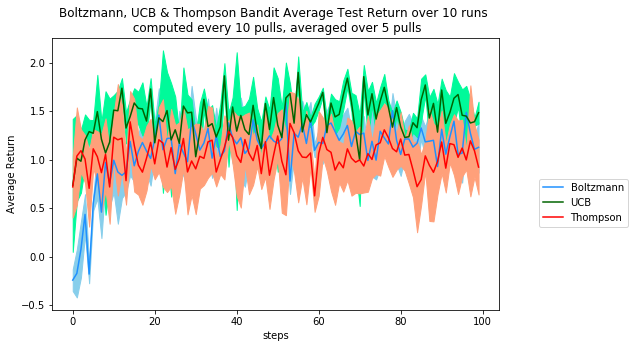

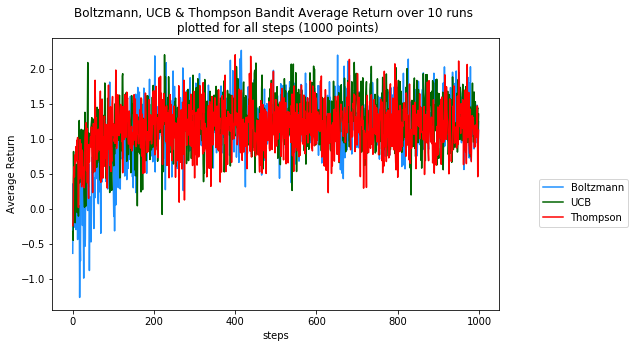

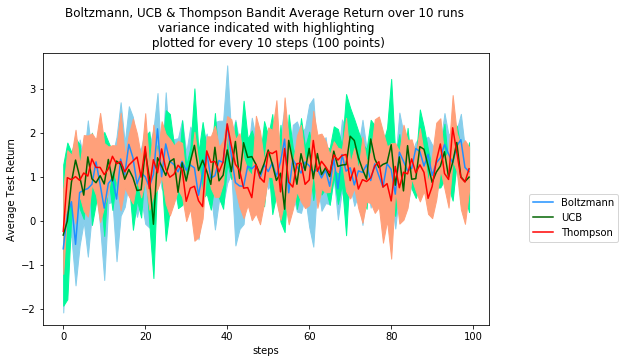

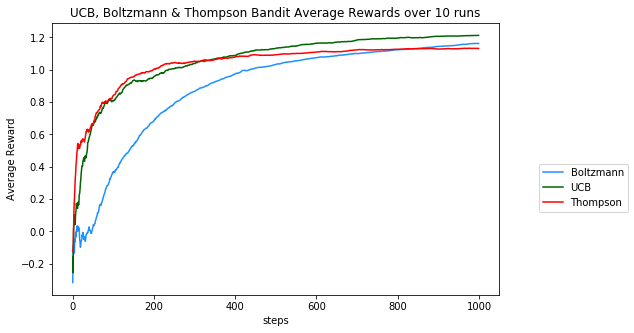

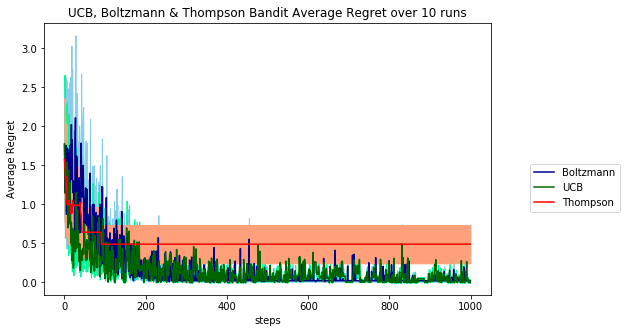

In [43]:
import matplotlib.pyplot as plt
import numpy as np 
import random

if __name__ == '__main__':
  seed = 10
  #seed =42
  #seed = 0.5
  #seed = 100
  k = 10
  c = 2
  alpha = 0.1 
  iters=1000
  training_steps=10
  test_steps=5
  random.seed(seed)
  repeat = 10

  ucb_value = np.zeros(iters)
  boltzmann_value = np.zeros(iters)
  th_value = np.zeros(iters)

  reward_ucb_list = np.zeros((repeat , iters))
  reward_boltzmann_list = np.zeros((repeat , iters))
  reward_thompson_list = np.zeros((repeat , iters))

  regret_ucb = np.zeros((repeat , iters))
  regret_boltzmann = np.zeros((repeat , iters))
  regret_thompson = np.zeros((repeat , iters))

  boltzmann_test_return = np.zeros((repeat ,iters//training_steps))
  ucb_test_return = np.zeros((repeat ,iters//training_steps))
  thompson_test_return = np.zeros((repeat ,iters//training_steps))

  # Initialize classes
  ucb = UCB(k,c,iters, seed)
  boltzmann = Boltzmann(k, alpha, iters, seed)
  th = Thompson(k,iters, seed)

  #runing experiments repetatively
  for i in range(repeat): 
      ucb.reset()
      boltzmann.reset()
      th.reset()

      # run experiments each 1000 iterations (time steps)
      ucb.run()
      boltzmann.run() 
      th.run()

      #Total value averaged over runs 
      boltzmann_value = boltzmann_value + (
          boltzmann.Q_total_iter - boltzmann_value) / (i + 1)
      ucb_value = ucb_value + (ucb.Q_total_iter - ucb_value) / (i + 1)
      th_value = th_value + (th.Q_total_iter - th_value) / (i + 1)

      # store rewards of all time steps for each run
      reward_ucb_list[i][:]= ucb.reward_iter
      reward_boltzmann_list[i][:]= boltzmann.reward_iter
      reward_thompson_list[i][:]= th.reward_iter
      
      # count regret for each time step
      regret_ucb[i][:] = np.repeat(np.amax(ucb.q_star) , iters) - ucb.selected_ac_true_value_iter
      regret_boltzmann[i][:] = np.repeat(np.amax(boltzmann.q_star) , iters) - boltzmann.selected_ac_true_value_iter
      regret_thompson[i][:] = np.repeat(np.amax(th.q_star) , iters) - th.selected_ac_true_value_iter

  ucb.reset()
  boltzmann.reset()
  th.reset()

#testing the algorithms
  for j in range(repeat):
    ucb.reset()
    boltzmann.reset()
    th.reset()
    for i in range(iters//training_steps):

        reward_test = boltzmann.test(training_steps, test_steps)
        boltzmann_test_return[j][i] = np.mean(reward_test)

        reward_test = ucb.test(training_steps, test_steps)
        ucb_test_return[j][i] = np.mean(reward_test)

        reward_test = th.test(training_steps, test_steps)
        thompson_test_return[j][i] = np.mean(reward_test)      

  ucb.reset()
  boltzmann.reset()
  th.reset()
  
  average_return_test_boltz = np.mean(boltzmann_test_return, axis=0)#mean
  average_return_test_ucb = np.mean(ucb_test_return, axis=0)#mean
  average_return_test_th = np.mean(thompson_test_return, axis=0)#mean

  var_average_return_test_boltz = np.var(boltzmann_test_return, axis=0)
  var_average_return_test_ucb = np.var(ucb_test_return, axis=0)
  var_average_return_test_th = np.var(thompson_test_return, axis=0)

  plt.figure(figsize=(8,5))
  plt.plot(average_return_test_boltz , label="Boltzmann" ,c='dodgerblue')
  x= range(100)
  plt.fill_between(x ,average_return_test_boltz-(var_average_return_test_boltz/2), 
                average_return_test_boltz+(var_average_return_test_boltz/2) , color='skyblue')
  #plt.plot(boltzmann_test_return[1] , label="Boltzmann")
  plt.plot(average_return_test_ucb , label="UCB" ,c='darkgreen')
  plt.fill_between(x ,average_return_test_ucb-(var_average_return_test_ucb/2), 
                average_return_test_ucb+(var_average_return_test_ucb/2) , color='mediumspringgreen')  
  #plt.plot(ucb_test_return[1] , label="UCB")
  plt.plot(average_return_test_th , label="Thompson" ,c='red')
  plt.fill_between(x ,average_return_test_th-(var_average_return_test_th/2), 
                average_return_test_th+(var_average_return_test_th/2) , color='lightsalmon')
  #plt.plot(thompson_test_return[1] , label="UCB")
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.title("Boltzmann, UCB & Thompson Bandit Average Test Return over "
            + str(repeat) + " runs" +  " \n computed every 10 pulls, averaged over 5 pulls")
  plt.xlabel("steps")
  plt.ylabel("Average Return")

  var_return_ucb = np.var(reward_ucb_list, axis=0)#variance
  average_return_ucb = np.mean(reward_ucb_list, axis=0)#mean

  var_return_boltzmann = np.var(reward_boltzmann_list, axis=0)#variance
  average_return_boltzmann = np.mean(reward_boltzmann_list, axis=0)#mean

  var_return_thompson = np.var(reward_thompson_list, axis=0)#variance
  average_return_thompson = np.mean(reward_thompson_list, axis=0)#mean

  #plotting average return : rewards for each step averaged over 10 runs
  # with 1000 points (all time steps)
  plt.figure(figsize=(8,5))
  plt.plot(average_return_boltzmann , label="Boltzmann" , c='dodgerblue')
  plt.plot(average_return_ucb , label="UCB" , c='darkgreen')
  plt.plot(average_return_thompson , label="Thompson" , c='red')
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.title("Boltzmann, UCB & Thompson Bandit Average Return over "
            + str(repeat) + " runs" +  " \n plotted for all steps (1000 points)")
  plt.xlabel("steps")
  plt.ylabel("Average Return")

  #plotting average return : rewards for each step averaged over 10 runs
  # with 100 points (for every 10 time steps)
  plt.figure(figsize=(8,5))
  x = range(100)
  plt.plot([average_return_boltzmann[10*j] for j in range(100)] , label="Boltzmann" , c='dodgerblue')
  plt.fill_between(x ,[average_return_boltzmann[10*j]-(var_return_boltzmann[10*j]/2) for j in range(100)], 
                  [average_return_boltzmann[10*j]+(var_return_boltzmann[10*j]/2) for j in range(100)] , color='skyblue')

  plt.plot(x ,[average_return_ucb[10*j] for j in range(100)] , label="UCB", c='darkgreen')
  plt.fill_between(x ,[average_return_ucb[10*j]-(var_return_ucb[10*j]/2) for j in range(100)], 
                  [average_return_ucb[10*j]+(var_return_ucb[10*j]/2) for j in range(100)] , color='mediumspringgreen')
  
  plt.plot(x ,[average_return_thompson[10*j] for j in range(100)] , label="Thompson", c='red')
  plt.fill_between(x ,[average_return_thompson[10*j]-(var_return_thompson[10*j]/2) for j in range(100)], 
                  [average_return_thompson[10*j]+(var_return_thompson[10*j]/2) for j in range(100)] , color='lightsalmon')
  
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.title("Boltzmann, UCB & Thompson Bandit Average Return over "
            + str(repeat) + " runs \n variance indicated with highlighting \n plotted for every 10 steps (100 points)")
  plt.xlabel("steps")
  plt.ylabel("Average Test Return")

  #plotting average rewards (Q value)
  plt.figure(figsize=(8,5))
  plt.plot(boltzmann_value, label="Boltzmann" , c='dodgerblue')
  plt.plot(ucb_value, label="UCB",c='darkgreen')
  plt.plot(th_value, label="Thompson",c='red')
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.xlabel("steps")
  plt.ylabel("Average Reward")
  plt.title("UCB, Boltzmann & Thompson Bandit Average Rewards over "
            + str(repeat) + " runs")

  #averaging over runs
  average_regret_ucb = np.mean(regret_ucb, axis=0)
  average_regret_boltzmann = np.mean(regret_boltzmann, axis=0)
  average_regret_thompson = np.mean(regret_thompson, axis=0)

  var_average_regret_ucb = np.mean(regret_ucb, axis=0)
  var_average_regret_boltzmann = np.mean(regret_boltzmann, axis=0)
  var_average_regret_thompson = np.mean(regret_thompson, axis=0)

  #plotting average regret for each time step over 10 runs
  plt.figure(figsize=(8,5))
  plt.plot(average_regret_boltzmann, label="Boltzmann", c='darkblue')
  x=range(1000)
  plt.fill_between(x ,average_regret_boltzmann-(var_average_regret_boltzmann/2), average_regret_boltzmann+(var_average_regret_boltzmann/2) , color='skyblue')
  plt.plot(average_regret_ucb, label="UCB" ,c='darkgreen')
  plt.fill_between(x ,average_regret_ucb-(var_average_regret_ucb/2), average_regret_ucb+(var_average_regret_ucb/2) , color='mediumspringgreen')  
  plt.plot(average_regret_thompson, label="Thompson" ,c='red')
  plt.fill_between(x ,average_regret_thompson-(var_average_regret_thompson/2), average_regret_thompson+(var_average_regret_thompson/2) , color='lightsalmon')
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.xlabel("steps")
  plt.ylabel("Average Regret")
  plt.title("UCB, Boltzmann & Thompson Bandit Average Regret over "
            + str(repeat) + " runs")

  plt.show()

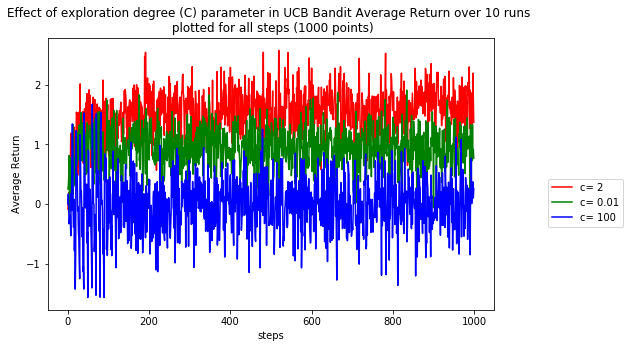

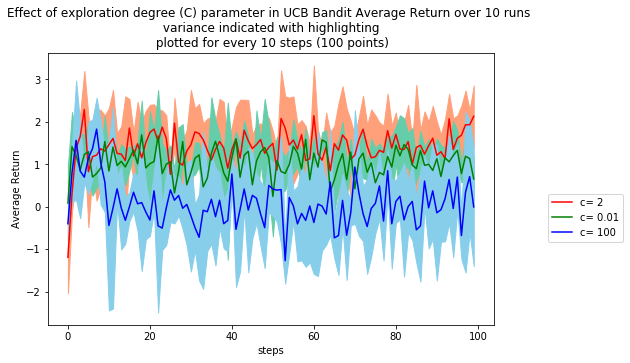

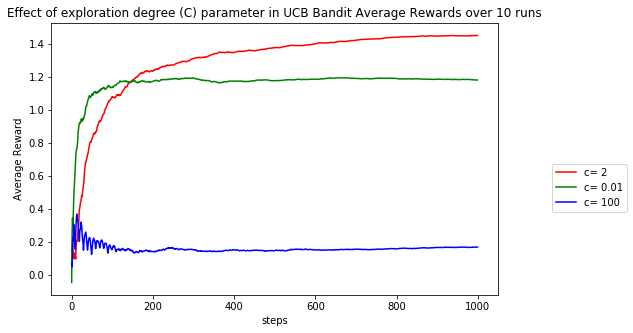

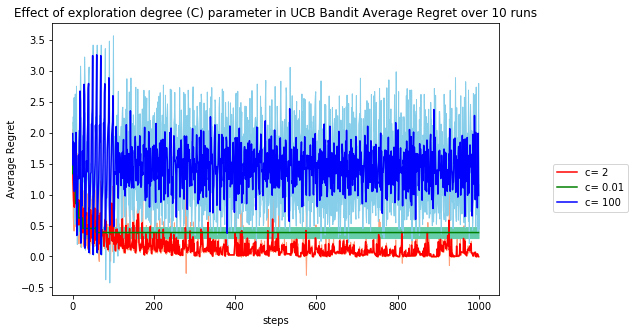

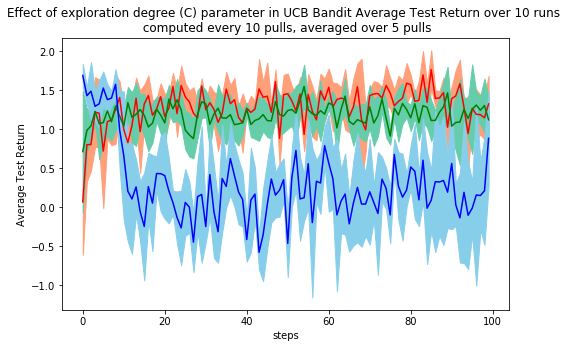

In [30]:
import matplotlib.pyplot as plt
import numpy as np 
import random

#UCB individual plots
if __name__ == '__main__':
  seed =42
  k = 10
  c = 2
  c_1 = 0.01
  c_2 = 100

  iters=1000
  training_steps=10
  test_steps=5
  random.seed(seed)
  repeat = 10

  ucb =[UCB(k,c,iters, seed) , UCB(k,c_1,iters, seed) , UCB(k,c_2,iters, seed)]

  def class_run(ucb , repeat, iters ,training_steps , test_steps):
    ucb_value = np.zeros(iters) 
    reward_ucb_list = np.zeros((repeat , iters))
    regret_ucb = np.zeros((repeat , iters))
    ucb_test_return = np.zeros((repeat ,iters//training_steps))

    #runing experiments repetatively
    for i in range(repeat): 
        ucb.reset()
        # run experiments each 1000 iterations (time steps)
        ucb.run()
        #Total value averaged over runs 
        ucb_value = ucb_value + (ucb.Q_total_iter - ucb_value) / (i + 1)

        # store rewards of all time steps for each run
        reward_ucb_list[i][:]= ucb.reward_iter
      
        # count regret for each time step
        regret_ucb[i][:] = np.repeat(np.amax(ucb.q_star) , iters) - ucb.selected_ac_true_value_iter

    ucb.reset()

    #testing the algorithms
    for j in range(repeat):
      ucb.reset()
      for i in range(iters//training_steps):
          reward_test = ucb.test(training_steps, test_steps)
          ucb_test_return[j][i] = np.mean(reward_test)

    ucb.reset()
    return ucb_value, reward_ucb_list, regret_ucb,ucb_test_return
  

  plt.figure(figsize=(8,5))
  color = ['r' ,'g' , 'b']
  shade = ['lightsalmon', 'mediumaquamarine' ,'skyblue' ]
  for i in range(3):    
    ucb_value, reward_ucb_list, regret_ucb, ucb_test_return = class_run (ucb[i], repeat, iters,training_steps , test_steps)
    var_return_ucb = np.var(reward_ucb_list, axis=0)#variance
    average_return_ucb = np.mean(reward_ucb_list, axis=0)#mean

    #plotting average return : rewards for each step averaged over 10 runs
    # with 1000 points (all time steps)
    
    plt.plot(average_return_ucb , label="c= "+ str(ucb[i].c) , c = color[i])
    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.title("Effect of exploration degree (C) parameter in UCB Bandit Average Return over "
            + str(repeat) + " runs" +  " \n plotted for all steps (1000 points)")
    plt.xlabel("steps")
    plt.ylabel("Average Return")
  
  plt.show()

  #plotting average return : rewards for each step averaged over 10 runs
  # with 100 points (for every 10 time steps)
  plt.figure(figsize=(8,5))
  
  for i in range(3):
    ucb_value, reward_ucb_list, regret_ucb, ucb_test_return = class_run (ucb[i], repeat, iters,training_steps , test_steps)
    var_return_ucb = np.var(reward_ucb_list, axis=0)#variance
    average_return_ucb = np.mean(reward_ucb_list, axis=0)#mean 
    x = range(100)

    plt.plot(x ,[average_return_ucb[10*j] for j in range(100)] , label="c= "+ str(ucb[i].c) , c = color[i])
    plt.fill_between(x ,[average_return_ucb[10*j]-(var_return_ucb[10*j]/2) for j in range(100)], 
                    [average_return_ucb[10*j]+(var_return_ucb[10*j]/2) for j in range(100)] , color= shade[i])

    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.title("Effect of exploration degree (C) parameter in UCB Bandit Average Return over "
              + str(repeat) + " runs \n variance indicated with highlighting \n plotted for every 10 steps (100 points)")
    plt.xlabel("steps")
    plt.ylabel("Average Return")
  plt.show()

  plt.figure(figsize=(8,5))
  for i in range(3):
    ucb_value, reward_ucb_list, regret_ucb, ucb_test_return = class_run (ucb[i], repeat, iters,training_steps , test_steps) 

    #plotting average rewards (Q value)
  
    plt.plot(ucb_value, label="c= "+ str(ucb[i].c) , c = color[i])
    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.xlabel("steps")
    plt.ylabel("Average Reward")
    plt.title("Effect of exploration degree (C) parameter in UCB Bandit Average Rewards over "
              + str(repeat) + " runs")
  plt.show()

  plt.figure(figsize=(8,5))
  for i in range(3):
    ucb_value, reward_ucb_list, regret_ucb, ucb_test_return = class_run (ucb[i], repeat, iters,training_steps , test_steps) 
    #averaging over runs
    average_regret_ucb = np.mean(regret_ucb, axis=0)
    var_average_regret_ucb = np.var(regret_ucb , axis=0)
    #plotting average regret for each time step over 10 runs
    
    plt.plot(average_regret_ucb, label="c= "+ str(ucb[i].c) , c = color[i])
    x = range(1000)
    plt.fill_between(x ,(average_regret_ucb-(var_average_regret_ucb/2)), 
                  (average_regret_ucb+(var_average_regret_ucb/2)) , color= shade[i])

    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.xlabel("steps")
    plt.ylabel("Average Regret")
    plt.title("Effect of exploration degree (C) parameter in UCB Bandit Average Regret over "
              + str(repeat) + " runs")
  plt.show()

  plt.figure(figsize=(8,5))
  for i in range(3):
    ucb_value, reward_ucb_list, regret_ucb, ucb_test_return = class_run (ucb[i], repeat, iters,training_steps , test_steps) 
    #plotting testing plots 
    average_return_test_ucb = np.mean(ucb_test_return, axis=0)#mean
    var_average_return_test_ucb = np.var(ucb_test_return , axis=0)#variance

    
    plt.plot(average_return_test_ucb , label="c= "+ str(ucb[i].c) , c = color[i] )
    x = range(100)
    plt.fill_between(x ,(average_return_test_ucb-(var_average_return_test_ucb/2)), 
                    (average_return_test_ucb+(var_average_return_test_ucb/2)) ,color= shade[i])
    #plt.plot(ucb_test_return[1] , label="UCB")
    plt.title("Effect of exploration degree (C) parameter in UCB Bandit Average Test Return over "
              + str(repeat) + " runs" +  " \n computed every 10 pulls, averaged over 5 pulls")
    plt.xlabel("steps")
    plt.ylabel("Average Test Return")

  plt.show()  




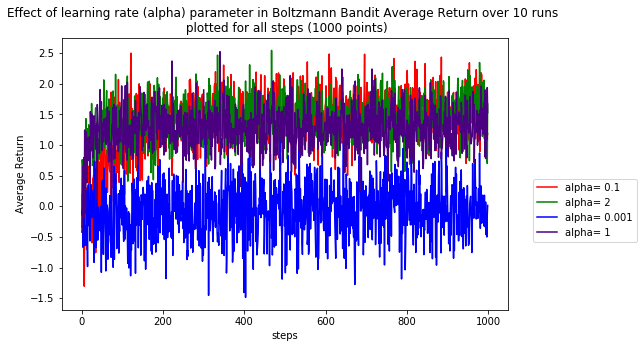

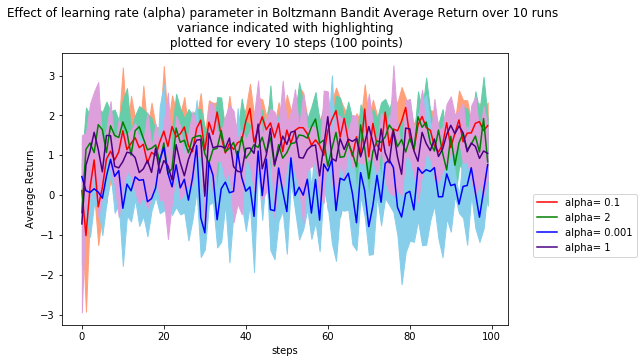

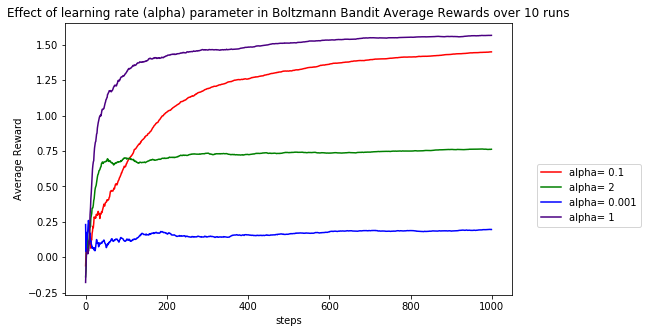

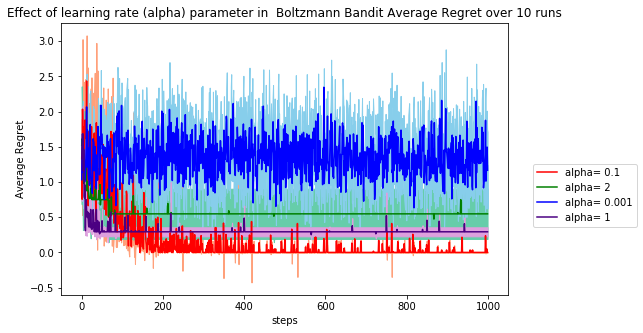

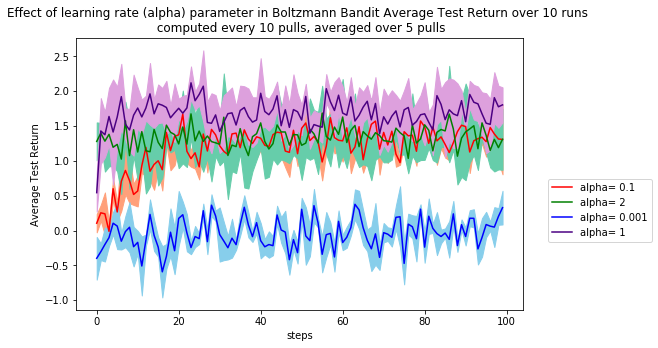

In [31]:
#Boltzmann individual plots
import matplotlib.pyplot as plt
import numpy as np 
import random

if __name__ == '__main__':
  seed =42
  k = 10
  alpha = 0.1
  alpha_1 = 2
  alpha_2 = 0.001
  alpha_3 = 1
  iters=1000
  training_steps=10
  test_steps=5
  random.seed(seed)
  repeat = 10

  boltzmann =[Boltzmann(k, alpha, iters, seed), Boltzmann(k, alpha_1, iters, seed),
              Boltzmann(k, alpha_2, iters, seed), Boltzmann(k, alpha_3, iters, seed)]

  def class_run(boltzmann , repeat, iters ,training_steps , test_steps):
    boltzmann_value = np.zeros(iters)
    reward_boltzmann_list = np.zeros((repeat , iters))
    regret_boltzmann = np.zeros((repeat , iters))
    boltzmann_test_return = np.zeros((repeat ,iters//training_steps))

    #runing experiments repetatively
    for i in range(repeat): 
        boltzmann.reset()

        # run experiments each 1000 iterations (time steps)
        boltzmann.run() 

        #Total value averaged over runs 
        boltzmann_value = boltzmann_value + (
            boltzmann.Q_total_iter - boltzmann_value) / (i + 1)

        # store rewards of all time steps for each run
        reward_boltzmann_list[i][:]= boltzmann.reward_iter
        
        # count regret for each time step
        regret_boltzmann[i][:] = np.repeat(np.amax(boltzmann.q_star) , iters) - boltzmann.selected_ac_true_value_iter

    boltzmann.reset()

    #testing the algorithms
    for j in range(repeat):
      boltzmann.reset()
      for i in range(iters//training_steps):

          reward_test = boltzmann.test(training_steps, test_steps)
          boltzmann_test_return[j][i] = np.mean(reward_test) 

    boltzmann.reset()
      
    return boltzmann_value, reward_boltzmann_list, regret_boltzmann,boltzmann_test_return
  
  #plotting average return : rewards for each step averaged over 10 runs
  # with 1000 points (all time steps)
  plt.figure(figsize=(8,5))
  color = ['r' ,'g' , 'b','indigo']
  shade = ['lightsalmon', 'mediumaquamarine' ,'skyblue' , 'plum']
  for i in range(4):    
    boltzmann_value, reward_boltzmann_list, regret_boltzmann,boltzmann_test_return = class_run (boltzmann[i], repeat, iters,training_steps , test_steps)
    var_return_boltzmann = np.var(reward_boltzmann_list, axis=0)#variance
    average_return_boltzmann = np.mean(reward_boltzmann_list, axis=0)#mean
    plt.plot(average_return_boltzmann , label="alpha= "+ str(boltzmann[i].alpha) , c = color[i])
    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.title("Effect of learning rate (alpha) parameter in Boltzmann Bandit Average Return over "
              + str(repeat) + " runs" +  " \n plotted for all steps (1000 points)")
    plt.xlabel("steps")
    plt.ylabel("Average Return")
  
  plt.show()

  #plotting average return : rewards for each step averaged over 10 runs
  # with 100 points (for every 10 time steps)
  plt.figure(figsize=(8,5))
  
  for i in range(4):
    boltzmann_value, reward_boltzmann_list, regret_boltzmann,boltzmann_test_return = class_run (boltzmann[i], repeat, iters,training_steps , test_steps)
    var_return_boltzmann = np.var(reward_boltzmann_list, axis=0)#variance
    average_return_boltzmann = np.mean(reward_boltzmann_list, axis=0)#mean

    x = range(100)
    plt.plot([average_return_boltzmann[10*j] for j in range(100)], label="alpha= "+ str(boltzmann[i].alpha) , c = color[i])
    plt.fill_between(x ,[average_return_boltzmann[10*j]-(var_return_boltzmann[10*j]/2) for j in range(100)], 
                    [average_return_boltzmann[10*j]+(var_return_boltzmann[10*j]/2) for j in range(100)] , color= shade[i])

    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.title("Effect of learning rate (alpha) parameter in Boltzmann Bandit Average Return over "
              + str(repeat) + " runs \n variance indicated with highlighting \n plotted for every 10 steps (100 points)")
    plt.xlabel("steps")
    plt.ylabel("Average Return")
  plt.show()

  #plotting average rewards (Q value)
  plt.figure(figsize=(8,5))
  for i in range(4):
    boltzmann_value, reward_boltzmann_list, regret_boltzmann,boltzmann_test_return = class_run (boltzmann[i], repeat, iters,training_steps , test_steps)

    plt.plot(boltzmann_value, label="alpha= "+ str(boltzmann[i].alpha) , c = color[i])
    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.xlabel("steps")
    plt.ylabel("Average Reward")
    plt.title("Effect of learning rate (alpha) parameter in Boltzmann Bandit Average Rewards over "
              + str(repeat) + " runs")

  plt.show()

  #plotting average regret for each time step over 10 runs
  plt.figure(figsize=(8,5))
  for i in range(4):

    boltzmann_value, reward_boltzmann_list, regret_boltzmann,boltzmann_test_return = class_run (boltzmann[i], repeat, iters,training_steps , test_steps)   
    #averaging over runs
    average_regret_boltzmann = np.mean(regret_boltzmann, axis=0)
    var_average_regret_boltzmann = np.var(regret_boltzmann, axis=0)
    x = range(1000)
    plt.plot(average_regret_boltzmann, label="alpha= "+ str(boltzmann[i].alpha) , c = color[i])
    plt.fill_between(x ,(average_regret_boltzmann-(var_average_regret_boltzmann/2)) , 
                    (average_regret_boltzmann+(var_average_regret_boltzmann/2)) , color= shade[i])
    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.xlabel("steps")
    plt.ylabel("Average Regret")
    plt.title("Effect of learning rate (alpha) parameter in  Boltzmann Bandit Average Regret over "
              + str(repeat) + " runs")
  plt.show()

  #plot testing plots
  plt.figure(figsize=(8,5))
  for i in range(4):
    boltzmann_value, reward_boltzmann_list, regret_boltzmann,boltzmann_test_return = class_run (boltzmann[i], repeat, iters,training_steps , test_steps)    
    
    average_return_test_boltz = np.mean(boltzmann_test_return, axis=0)#mean
    var_average_return_test_boltz = np.var(boltzmann_test_return, axis=0)#variance
    plt.plot(average_return_test_boltz , label="alpha= "+ str(boltzmann[i].alpha) , c = color[i])
    #plt.plot(boltzmann_test_return[1] , label="Boltzmann")
    x = range(100)
    plt.fill_between(x ,(average_return_test_boltz-(var_average_return_test_boltz/2)) , 
                    (average_return_test_boltz+(var_average_return_test_boltz/2)) , color= shade[i])

    plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
    plt.title("Effect of learning rate (alpha) parameter in Boltzmann Bandit Average Test Return over "
              + str(repeat) + " runs" +  " \n computed every 10 pulls, averaged over 5 pulls")
    plt.xlabel("steps")
    plt.ylabel("Average Test Return")

  plt.show()


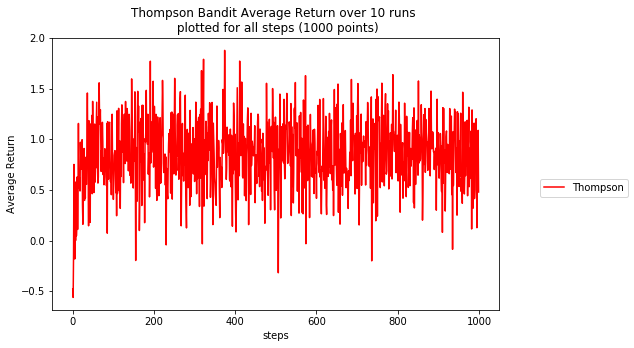

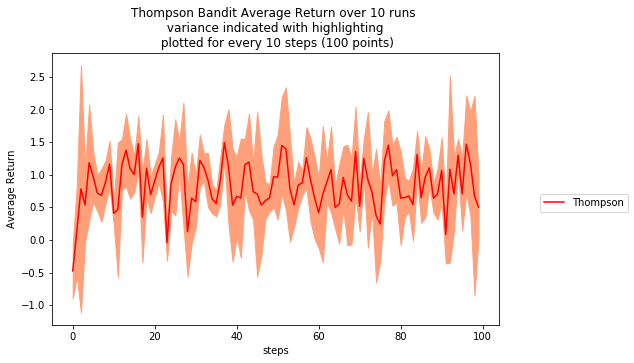

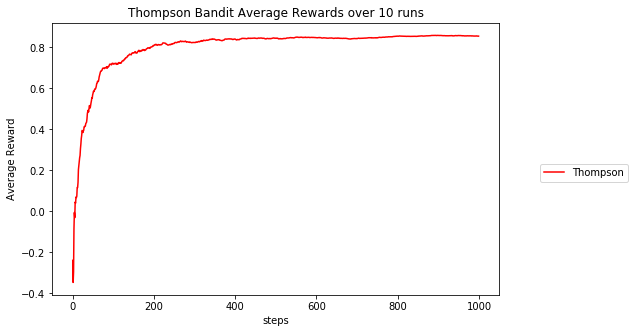

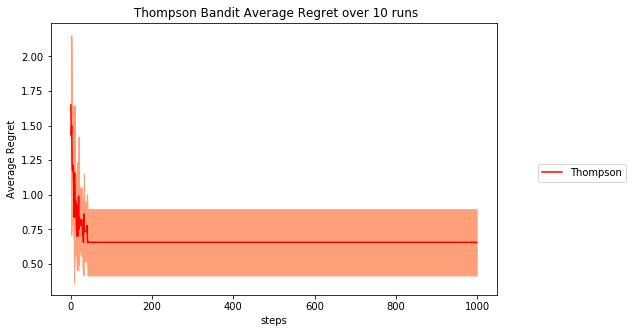

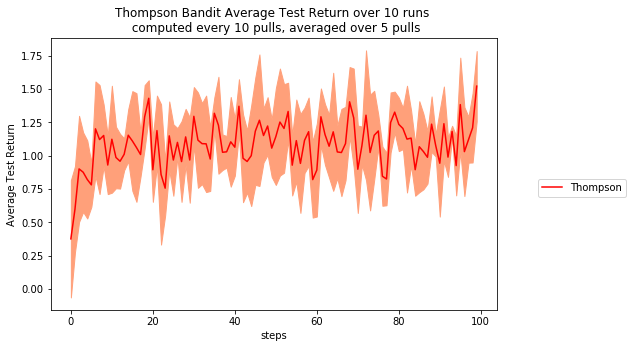

In [32]:
#Thomson sampling individual plots

import matplotlib.pyplot as plt
import numpy as np 
import random

if __name__ == '__main__':
  seed =42
  k = 10

  iters=1000
  training_steps=10
  test_steps=5
  random.seed(seed)
  repeat = 10

  th_value = np.zeros(iters)

  reward_thompson_list = np.zeros((repeat , iters))

  regret_thompson = np.zeros((repeat , iters))

  thompson_test_return = np.zeros((repeat ,iters//training_steps))

  # Initialize classes
  th = Thompson(k,iters, seed)

  #runing experiments repetatively
  for i in range(repeat): 
      th.reset()

      # run experiments each 1000 iterations (time steps) 
      th.run()

      #Total value averaged over runs 

      th_value = th_value + (th.Q_total_iter - th_value) / (i + 1)

      # store rewards of all time steps for each run

      reward_thompson_list[i][:]= th.reward_iter
      
      # count regret for each time step

      regret_thompson[i][:] = np.repeat(np.amax(th.q_star) , iters) - th.selected_ac_true_value_iter


  th.reset()

#testing the algorithms
  for j in range(repeat):

    th.reset()
    for i in range(iters//training_steps):

        reward_test = th.test(training_steps, test_steps)
        thompson_test_return[j][i] = np.mean(reward_test)      

  th.reset()

  var_return_thompson = np.var(reward_thompson_list, axis=0)#variance
  average_return_thompson = np.mean(reward_thompson_list, axis=0)#mean

  #plotting average return : rewards for each step averaged over 10 runs
  # with 1000 points (all time steps)
  plt.figure(figsize=(8,5))
  plt.plot(average_return_thompson , label="Thompson" , c='red')
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.title("Thompson Bandit Average Return over "
            + str(repeat) + " runs" +  " \n plotted for all steps (1000 points)")
  plt.xlabel("steps")
  plt.ylabel("Average Return")

  #plotting average return : rewards for each step averaged over 10 runs
  # with 100 points (for every 10 time steps)
  plt.figure(figsize=(8,5))
  x = range(100)
  
  plt.plot(x ,[average_return_thompson[10*j] for j in range(100)] , label="Thompson", c='red')
  plt.fill_between(x ,[average_return_thompson[10*j]-(var_return_thompson[10*j]/2) for j in range(100)], 
                  [average_return_thompson[10*j]+(var_return_thompson[10*j]/2) for j in range(100)] , color='lightsalmon')
  
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.title("Thompson Bandit Average Return over "
            + str(repeat) + " runs \n variance indicated with highlighting \n plotted for every 10 steps (100 points)")
  plt.xlabel("steps")
  plt.ylabel("Average Return")

  #plotting average rewards (Q value)
  plt.figure(figsize=(8,5))
  plt.plot(th_value, label="Thompson",c='red')
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.xlabel("steps")
  plt.ylabel("Average Reward")
  plt.title("Thompson Bandit Average Rewards over "
            + str(repeat) + " runs")

  #averaging over runs
  average_regret_thompson = np.mean(regret_thompson, axis=0)
  var_average_regret_thompson = np.var(regret_thompson, axis=0)
  #plotting average regret for each time step over 10 runs
  plt.figure(figsize=(8,5))
  plt.plot(average_regret_thompson, label="Thompson" ,c='red')
  x= range(1000)
  plt.fill_between(x ,(average_regret_thompson-(var_average_regret_thompson/2)) , 
                  (average_regret_thompson+(var_average_regret_thompson/2)) , color='lightsalmon')
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.xlabel("steps")
  plt.ylabel("Average Regret")
  plt.title(" Thompson Bandit Average Regret over "
            + str(repeat) + " runs")
  
  # plot testing plots  
  average_return_test_th = np.mean(thompson_test_return, axis=0)#mean
  var_average_return_test_th = np.var(thompson_test_return, axis=0)#variance
  plt.figure(figsize=(8,5))

  plt.plot(average_return_test_th , label="Thompson" ,c='red')
  x= range(100)
  plt.fill_between(x ,(average_return_test_th-(var_average_return_test_th/2)) , 
                  (average_return_test_th+(var_average_return_test_th/2)) , color='lightsalmon')
  #plt.plot(thompson_test_return[1] , label="UCB")
  plt.legend(bbox_to_anchor=(1.3, 0.5) , loc = 'best')
  plt.title("Thompson Bandit Average Test Return over "
            + str(repeat) + " runs" +  " \n computed every 10 pulls, averaged over 5 pulls")
  plt.xlabel("steps")
  plt.ylabel("Average Test Return")

  plt.show()